In [13]:
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sigpyproc.readers import FilReader
import astropy.units as u
from astropy.time import Time
from astropy.io import fits
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator
from astropy.visualization import ImageNormalize, PercentileInterval
from tqdm import tqdm

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00' # use precise epoch
try: mdates.set_epoch('1970-01-01T00:00:00')
except: pass

machine = 'dias' # dias or nancep

if machine=='dias': # on dias machines
    lofar_path = '/home/mnedal/data/I-LOFAR'
    data_dir = '/home/mnedal/data/ORFEES'
    folder_path = '/home/mnedal/data/pkl_files'
    outputs = '/home/mnedal/data/png'

elif machine=='nancep': # on nancep node
    data_dir = '/home/mnedal/data'
    folder_path = '/home/mnedal/outputs/data'
    outputs = '/home/mnedal/outputs/plots'

In [14]:
mydate = '2025-03-26'

year, month, day = mydate.split('-')

## Load ORFEES data

In [15]:
orfees_filename = f'{folder_path}/orfees/orfees_{mydate}.pkl'

if os.path.exists(orfees_filename):
    print('ORFEES DataFrame exists, loading it ..')
    df_orfees = pd.read_pickle(orfees_filename)
    display(df_orfees.head(3)) # sanity check

else:
    print('ORFEES DataFrame not exist, making one ..')
    files = glob.glob(f'{data_dir}/int_orf{year}{month}{day}_*.fts')
    
    orfees = fits.open(files[0])
    orfees_i = np.hstack([orfees[2].data[f'STOKESI_B{i}'] for i in range(1, 6)]).T
    orfees_data = orfees_i.T
    
    orfees_time_str = orfees[0].header['DATE-OBS']
    orfees_times = Time(orfees_time_str) + (orfees[2].data['TIME_B1']/1000)*u.s # times are not the same for all sub spectra!
    orfees_freqs = np.hstack([orfees[1].data[f'FREQ_B{i}'] for i in range(1, 6)])*u.MHz
    
    # convert ORFEES data to a DataFrame and plot it to determine the quiet period, which will be divided by later.
    df_orfees = pd.DataFrame(data=orfees_data, index=orfees_times, columns=orfees_freqs.value.flatten())
    df_orfees.index = [t.datetime for t in df_orfees.index]
    display(df_orfees.head(3)) # sanity check
    
    # Export the ORFEES spectrum .. TO-DO: MOVE THIS PART TO THE OTHER NOTEBOOK OF ORFEES PROCESSING)
    df_orfees.to_pickle(orfees_filename)

ORFEES DataFrame exists, loading it ..


,144.130005,144.520004,144.910004,145.300003,145.690002,146.960007,148.089996,148.429993,148.820007,149.210007,...,990.729980,992.289978,993.859985,995.419983,996.979980,998.539978,1000.109985,1001.669983,1003.229980,1004.700012
2025-03-26 07:46:43.580,41.720001,50.66,57.477501,54.875,56.982502,56.875,55.130001,55.315002,54.660000,55.592503,...,41.669376,40.091873,46.627499,39.463123,39.887505,47.371876,44.288128,49.587498,53.906246,68.492859
2025-03-26 07:46:43.680,41.720001,50.66,55.987503,54.875,58.485001,55.250,53.639999,55.315002,55.032501,54.110001,...,41.669376,39.203125,46.137501,41.395000,39.887505,47.371876,45.543751,47.918751,53.906246,68.492859
2025-03-26 07:46:43.780,41.720001,50.66,55.987503,54.875,57.082500,54.430,54.633335,54.195000,55.029999,55.592499,...,42.108749,38.285000,45.644375,40.434372,40.853127,46.748123,46.193752,48.718746,53.906246,68.557144


In [66]:
# Downsample to 1s Res.
df_orfees_1s = df_orfees.resample('1S').mean()

In [67]:
# Automatically detect quiet periods
def find_quiet_periods(df, window='10S', quant=0.1, std_thresh=None, use_median=True, iqr_multiplier=1.5):
    """
    Identify quiet times in a radio spectrogram based on low spectral variability.

    Parameters:
        df (pd.DataFrame): 2D data with shape (time, frequency) in SFU units.
        window (str): Rolling window size (e.g., '10S' for 10 seconds).
        quant (float): Quantile to use when estimating std_thresh if not provided.
        std_thresh (float or None): If provided, use this absolute threshold for std.
        use_median (bool): Whether to aggregate std across frequencies using median (more robust) or mean.
        iqr_multiplier (float): Multiplier for IQR if using automated thresholding based on boxplot rule.

    Returns:
        pd.DatetimeIndex: Timestamps of detected quiet periods.
    """
    rolling_std = df.rolling(window).std()
    agg_std = rolling_std.median(axis=1) if use_median else rolling_std.mean(axis=1)

    if std_thresh is None:
        Q1 = agg_std.quantile(0.25)
        Q3 = agg_std.quantile(0.75)
        IQR = Q3 - Q1
        std_thresh = Q1 - iqr_multiplier * IQR

    quiet_times = df.index[agg_std < std_thresh]
    return quiet_times

In [69]:
# Apply to ORFEES and Convert SFU to dB
# Find quiet times in ORFEES
quiet_times_orf = find_quiet_periods(df_orfees_1s, window='10S', iqr_multiplier=1.4)

# Compute median power level in quiet time — used as dB reference
orf_ref_sfu = df_orfees_1s.loc[quiet_times_orf].median().median()

# Convert SFU to dB
orfees_db = 10 * np.log10(df_orfees_1s / orf_ref_sfu)

## Load I-LOFAR data

In [16]:
ilofar_files = sorted(glob.glob(f'{lofar_path}/Sun357_{mydate}*.fil'))
print(*ilofar_files, sep='\n')

/home/mnedal/data/I-LOFAR/Sun357_2025-03-26T08:31:00_StokesI_dyspec.fil
/home/mnedal/data/I-LOFAR/Sun357_2025-03-26_typeII_1.fil
/home/mnedal/data/I-LOFAR/Sun357_2025-03-26_typeII_2.fil


In [41]:
filename = ilofar_files[0]
mytime = filename.split(f'{mydate}T')[-1].split('_')[0]
stokes = filename.split(f'{mydate}T')[-1].split('_')[1]
a = FilReader(filename) # header
header = a.header.to_dict()
tstart_obs_str = Time(a.header.tstart, format='mjd').iso
n_samples = a.header.nsamples
data = a.read_block(start=0, nsamps=n_samples)
print(tstart_obs_str, n_samples, sep='\n')

2025-03-26 09:01:00.000
1327514


In [21]:
# making time axis
tstart = Time(data.header.tstart, format='mjd')                    # tstart.iso will tell the time in format yyyy-mm-dd hh:mm:ss
tarray = tstart + (np.arange(data.shape[1])*data.header.tsamp*u.s) # making the time array for realta time resolution
print(len(tarray), tarray[0].iso, tarray[-1].iso, sep='\n')

1327514
2025-03-26 09:01:00.000
2025-03-26 09:29:59.998


In [22]:
dt = datetime.strptime(tarray[1].iso, '%Y-%m-%d %H:%M:%S.%f') - datetime.strptime(tarray[0].iso, '%Y-%m-%d %H:%M:%S.%f')
print('Time cadence:', dt.total_seconds()*1000, 'ms.')

Time cadence: 1.0 ms.


In [23]:
# Converting the array to datetime object --> expand the for-loop and use tqdm since this step takes a long time!        
Tarray = []
with tqdm(total=len(tarray), desc='Converting time array to datetime object') as pbar:
    for t in tarray:
        tmp_var = datetime.strptime(t.iso, '%Y-%m-%d %H:%M:%S.%f')
        Tarray.append(tmp_var)
        pbar.update(1)

print(Tarray[0], Tarray[-1], sep='\n')

Converting time array to datetime object: 100%|███████████████████| 1327514/1327514 [06:36<00:00, 3345.37it/s]

2025-03-26 09:01:00
2025-03-26 09:29:59.998000


In [24]:
# export the frequency axis
freqs = data.header.chan_freqs
print(freqs[0], freqs[-1], sep='\n')

200.0
104.8828125


In [26]:
def freq_axis(freqs):
    """
    Introduce gaps in the frequency axis of I-LOFAR REALTA data.
    """
    gap1 = np.flipud(freqs[288]+(np.arange(59)*0.390625))
    gap2 = np.flipud(freqs[88]+(np.arange(57)*0.390625))
    ax_shape = 59+57-1
    new_freq = np.zeros(ax_shape+freqs.shape[0])
    
    new_freq[0:88]    = freqs[0:88]
    new_freq[88:145]  = gap2[:57]
    new_freq[145:345] = freqs[88:288]
    new_freq[345:404] = gap1[:59]
    new_freq[404:]    = freqs[289:]
    
    return new_freq

In [27]:
new_freq = freq_axis(freqs)

data = np.log10(data)
data[np.where(np.isinf(data)==True)] = 0.0

data2 = np.empty((new_freq.shape[0], data.shape[1]))    
data2[:] = np.NaN
data2[0:88] = data[0:88]
data2[145:345] = data[88:288]
data2[404:] = data[289:]

In [30]:
freq_mode3 = np.linspace(10, 90, 199)
freq_mode5 = np.linspace(110, 190, 200)
freq_mode7 = np.linspace(210, 270, 88)

df_mode3 = pd.DataFrame(data=data2[404:].T, columns=freq_mode3[::-1])
df_mode5 = pd.DataFrame(data=data2[145:345].T, columns=freq_mode5[::-1])
df_mode7 = pd.DataFrame(data=data2[:88].T, columns=freq_mode7[::-1])

# Ensure the 'time' column is in datetime format
df_mode3.index = pd.to_datetime(Tarray)
df_mode5.index = pd.to_datetime(Tarray)
df_mode7.index = pd.to_datetime(Tarray)

print(df_mode3.shape, df_mode5.shape, df_mode7.shape, sep='\n')

(1327514, 199)
(1327514, 200)
(1327514, 88)


In [42]:
# Save the dataframes as a pickle files
if not os.path.exists(f'{folder_path}/df_mode3_realta_{mydate}T{mytime}_{stokes}.pkl'):
    df_mode3.to_pickle(f'{folder_path}/df_mode3_realta_{mydate}T{mytime}_{stokes}.pkl')

if not os.path.exists(f'{folder_path}/df_mode5_realta_{mydate}T{mytime}_{stokes}.pkl'):
    df_mode5.to_pickle(f'{folder_path}/df_mode5_realta_{mydate}T{mytime}_{stokes}.pkl')

if not os.path.exists(f'{folder_path}/df_mode7_realta_{mydate}T{mytime}_{stokes}.pkl'):
    df_mode7.to_pickle(f'{folder_path}/df_mode7_realta_{mydate}T{mytime}_{stokes}.pkl')

In [43]:
time_mode3 = df_mode3.index
time_mode5 = df_mode5.index
time_mode7 = df_mode7.index

freq_mode3 = df_mode3.columns
freq_mode5 = df_mode5.columns
freq_mode7 = df_mode7.columns

In [44]:
# Downsample to 1-second resolution for faster testing and visualization
df_mode3_1s = df_mode3.resample('1S').mean()
df_mode5_1s = df_mode5.resample('1S').mean()
df_mode7_1s = df_mode7.resample('1S').mean()

## Slice ORFEES to match I-LOFAR

In [71]:
start_time = df_mode3_1s.index[0]
end_time   = df_mode3_1s.index[-1]

start_nearest = orfees_db.index.asof(start_time)
end_nearest   = orfees_db.index.asof(end_time)

subdf_orfees = orfees_db.loc[start_nearest:end_nearest]

print(subdf_orfees.index[0], subdf_orfees.index[-1])

2025-03-26 09:01:00 2025-03-26 09:29:59


In [72]:
# sanity check
dt_start = np.abs(df_mode3_1s.index[0] - subdf_orfees.index[0]).total_seconds()*u.s.to('ms')
dt_end = np.abs(df_mode3_1s.index[-1] - subdf_orfees.index[-1]).total_seconds()*u.s.to('ms')

print(f'Difference in start times: {dt_start} ms')
print(f'Difference in end times: {dt_end} ms')

Difference in start times: 0.0 ms
Difference in end times: 0.0 ms


## Remove constant background

In [73]:
df_orfees_1s_nobkg = subdf_orfees - np.tile(np.nanmedian(subdf_orfees,0), (subdf_orfees.shape[0],1))
df_mode3_1s_nobkg = df_mode3_1s - np.tile(np.nanmedian(df_mode3_1s,0), (df_mode3_1s.shape[0],1))
df_mode5_1s_nobkg = df_mode5_1s - np.tile(np.nanmedian(df_mode5_1s,0), (df_mode5_1s.shape[0],1))
df_mode7_1s_nobkg = df_mode7_1s - np.tile(np.nanmedian(df_mode7_1s,0), (df_mode7_1s.shape[0],1))

## Plotting

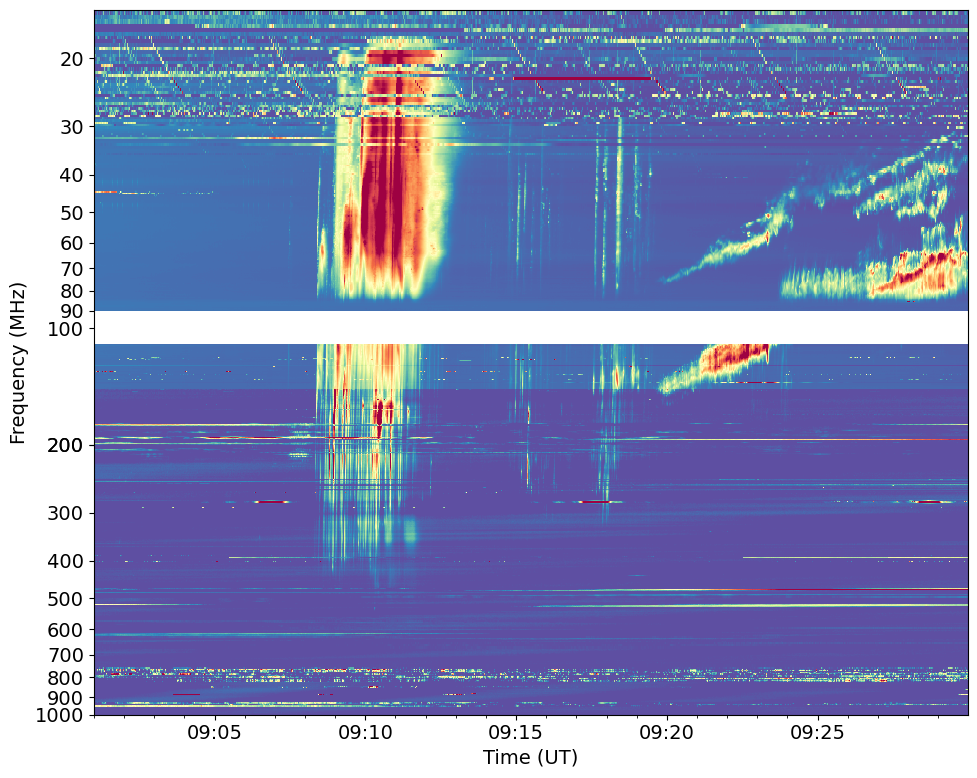

In [86]:
fig = plt.figure(figsize=[10,8])
ax  = fig.add_subplot(111)

# Top panel: I-LOFAR
min_range = -0.1
max_range = 1.7
ax.pcolormesh(df_mode3_1s_nobkg.index, df_mode3_1s_nobkg.columns, df_mode3_1s_nobkg.values.T,
              vmin=min_range, vmax=max_range, cmap='Spectral_r')
ax.pcolormesh(df_mode5_1s_nobkg.index, df_mode5_1s_nobkg.columns, df_mode5_1s_nobkg.values.T,
              vmin=min_range, vmax=max_range, cmap='Spectral_r')
ax.pcolormesh(df_mode7_1s_nobkg.index, df_mode7_1s_nobkg.columns, df_mode7_1s_nobkg.values.T,
              vmin=min_range, vmax=max_range, cmap='Spectral_r')
ax.set_ylim(bottom=15)

# Bottom panel: ORFEES
ax.pcolormesh(df_orfees_1s_nobkg.index, df_orfees_1s_nobkg.columns, df_orfees_1s_nobkg.T,
              vmin=0, vmax=4, cmap='Spectral_r')

# Axes settings
ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])  # Reverse Y axis for frequency descending

# Tick settings
custom_ticks = [20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(custom_ticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [ ]:
if not os.path.exists(f'{outputs}/ilofar_orfees_dyspec_{mydate}.png'):
    fig.savefig(f'{outputs}/ilofar_orfees_dyspec_{mydate}.png', format='png', dpi=300, bbox_inches='tight')

In [80]:
# fig = plt.figure(figsize=[10,5])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(df_orfees_1s_nobkg.index, df_orfees_1s_nobkg.columns, df_orfees_1s_nobkg.T,
#                    vmin=0, vmax=4,
#                    # vmin=min_range, vmax=max_range,
#                    cmap='Spectral_r')
# ax.set_yscale('log')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_ylim(ax.get_ylim()[::-1])
# yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
# ax.set_yticks(yticks)
# ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()